In [32]:
from os import walk, path, listdir
import time
from multiprocessing import Process, Queue
import bagpy
import rospy
from bagpy import bagreader
import pandas as pd
import numpy as np
from matplotlib import pyplot, patches
from matplotlib.patches import Circle
from shapely.geometry import Polygon, MultiPoint, LineString, MultiLineString

BAG_PATH = '/home/patrik/catkin_ws/src/multi_drone_sar/data/bagfiles/houses'
DRONE_COLORS = ['#00FF00', '#FF0000', '#0000FF', '#FF00FF']
DRONE_AMOUNT = 4
DRONE_IDXS = range(1, DRONE_AMOUNT+1)
pyplot.rcParams.update({'font.size': 22})

def topic_to_csvname(topic):
    if topic[0] == '/':
        topic = topic[1:]
    return topic.replace('/', '-') + '.csv'

def get_messages(bagname, topic):
    csvname = topic_to_csvname(topic)
    csvfile = path.join(BAG_PATH, bagname, csvname)
    return pd.read_csv(csvfile)

In [33]:
# read bag files or CSVs from multiple runs atleast 10, 20 would be good

_, folders, files = next(walk(BAG_PATH))
bagfiles = [path.join(BAG_PATH, bag) for bag in files if bag.endswith('.bag')]
bagnames = [path.splitext(path.basename(f))[0] for f in bagfiles]
for f in folders:
    if f not in bagnames:
        bagnames.append(f)
print(f'Bag files found: {len(bagnames)}')

def message_by_topic(bag, topic, existing_files):
    csvname = topic_to_csvname(topic)
    if csvname not in existing_files:
        bag.message_by_topic(topic)

def prepare_bag(bagfile):
    bagfilename = path.splitext(bagfile)[0]
    files = []
    if path.isdir(bagfilename):
        files = listdir(bagfilename)
    bag = bagreader(bagfile)
    if 'people_and_time.csv' not in files:
        message_by_topic(bag, '/people_and_time', files)
    for i in DRONE_IDXS:
        message_by_topic(bag, f'/drone_{i}/task_allocation/task_complete', files)
        message_by_topic(bag, f'/drone_{i}/navigation/status', files)
        message_by_topic(bag, f'/airsim_node/drone_{i}/odom_local_ned', files)
        message_by_topic(bag, f'/drone_{i}/current_charge_level', files)


processes = []
for f, n in zip(bagfiles, bagnames):
    p = Process(target=prepare_bag, args=(f,))
    p.start()
    processes.append(p)
for p in processes:
    p.join()


Bag files found: 20


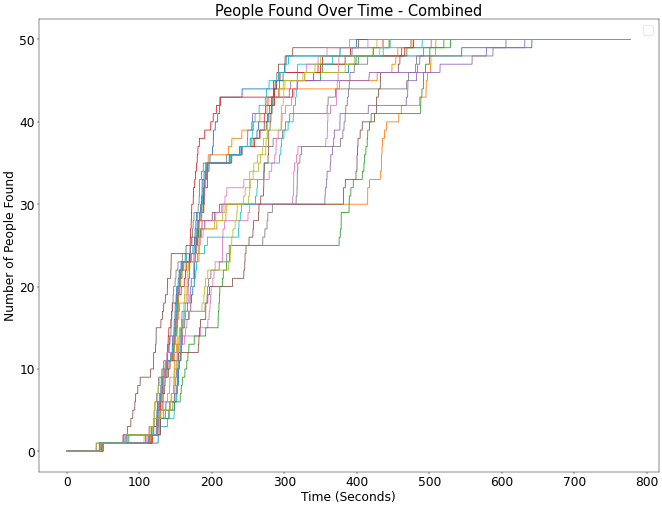

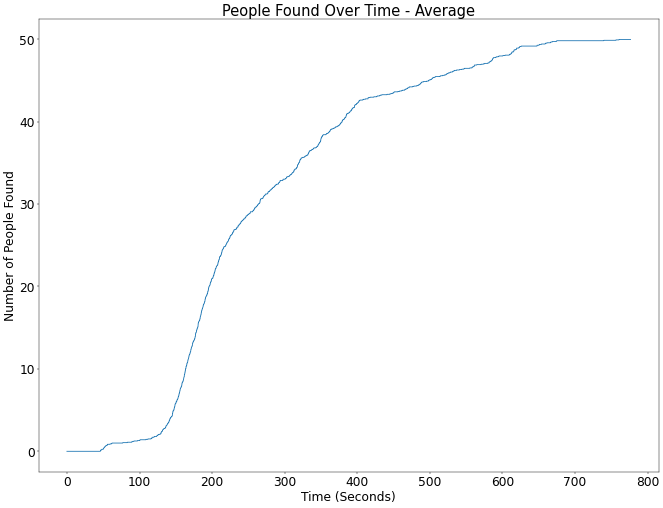

In [34]:
pyplot.figure(1, figsize=(20, 15.0), dpi=40)
pyplot.ylabel('Number of People Found')
pyplot.xlabel('Time (Seconds)')
pyplot.title('People Found Over Time - Combined')
pyplot.legend([f'drone_{i}' for i in DRONE_IDXS])
pyplot.figure(2, figsize=(20, 15.0), dpi=40)
pyplot.ylabel('Number of People Found')
pyplot.xlabel('Time (Seconds)')
pyplot.title('People Found Over Time - Average')
average_people_found = np.array([])
min_time = None
for name in bagnames:
    df_pat = get_messages(name, '/people_and_time')
    _time = df_pat['Time'].to_numpy()
    _time -= _time[0]
    if min_time is None:
        min_time = _time
    elif min_time.size > _time.size:
        min_time = _time
    people_found = df_pat['people_found'].to_numpy()
    pyplot.figure(1)
    pyplot.plot(_time, people_found)
    if average_people_found.size == 0:
        average_people_found = np.zeros(people_found.shape[0])
    elif people_found.shape[0] < average_people_found.shape[0]:
        average_people_found = average_people_found[0:people_found.shape[0]]
    elif people_found.shape[0] > average_people_found.shape[0]:
        people_found = people_found[0:average_people_found.shape[0]]
    
    average_people_found += people_found
average_people_found /= len(bagnames)
pyplot.savefig(f'{BAG_PATH}/people_found_over_time_for_all_runs.pdf', bbox_inches='tight', dpi=600)
pyplot.figure(2)
pyplot.plot(min_time, average_people_found)
pyplot.savefig(f'{BAG_PATH}/average_people_found_over_time.pdf', bbox_inches='tight', dpi=600)
pyplot.show()

In [35]:
# print average tasks completed by each drone
average_task_comp = np.zeros(DRONE_AMOUNT)
for name in bagnames:
    for i in DRONE_IDXS:
        df_tc = get_messages(name, f'/drone_{i}/task_allocation/task_complete')
        average_task_comp[i-1] += len(df_tc.index)
average_task_comp /= len(bagnames)
print('Average task completions for each drone:')
for i, c in enumerate(average_task_comp):
    print(f'drone_{i+1}: {c}')


Average task completions for each drone:
drone_1: 33.0
drone_2: 31.35
drone_3: 32.4
drone_4: 19.7


--- 1889.3578429222107 seconds ---
Average drone pathing length:
drone_1: 2395.034319512317
drone_2: 2422.2105385540362
drone_3: 2416.3294841244665
drone_4: 2433.3669827366507
The drones covered an average of 99.9909326632977 % total area


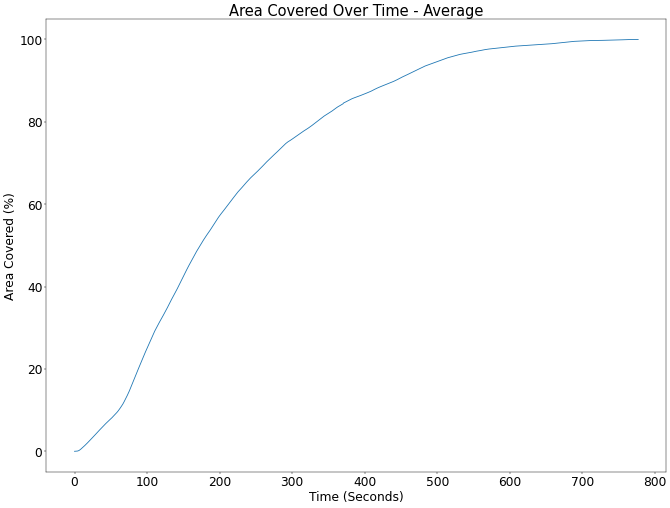

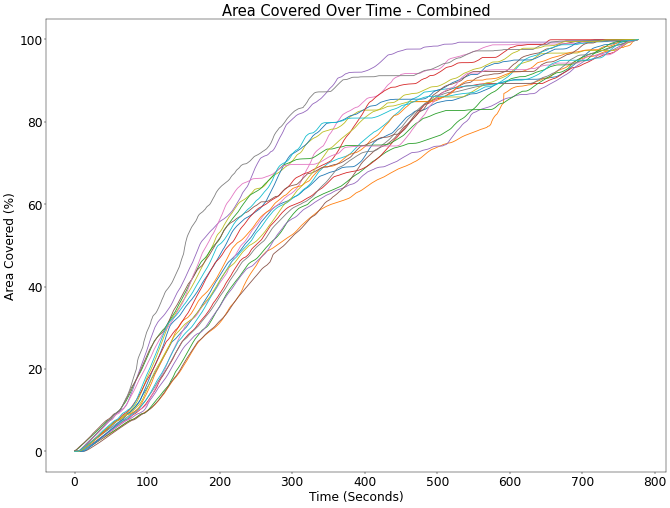

In [36]:
# print average drone pathing length
pyplot.figure(3, figsize=(20, 15.0), dpi=40)
pyplot.ylabel('Area Covered (%)')
pyplot.xlabel('Time (Seconds)')
pyplot.title('Area Covered Over Time - Average')
pyplot.figure(4, figsize=(20, 15.0), dpi=40)
pyplot.ylabel('Area Covered (%)')
pyplot.xlabel('Time (Seconds)')
pyplot.title('Area Covered Over Time - Combined')


big_square = [(0, 0), (0, 400), (400, 400), (400, 0), (0, 0)]
polygon_big = Polygon(big_square)
average_path_length = np.zeros(DRONE_AMOUNT)
same_count = 0
average_coverage = []
min_line_length = 0
def get_coverage(points, map_poly, q):
    min_len = min([len(l) for l in points])
    average_coverage = []
    for i in range(1, min_len):
        lines = []
        for idx, p in enumerate(points):
            line = LineString(p[:i+1])
            lines.append(line)
        multiline = MultiLineString(lines)
        dilated = multiline.buffer(30, join_style=1)
        difference = map_poly.difference(dilated)
        covered_area = map_poly.area - difference.area
        coverage = (covered_area  / map_poly.area) * 100
        average_coverage.append(coverage)
        if coverage > 99.99:
            break
    q.put(average_coverage)

processes = []
q = Queue()
start_time = time.time()
tot_time = 0
for name in bagnames:
    drone_points = []
    for i in DRONE_IDXS:
        df_odom = get_messages(name, f'/airsim_node/drone_{i}/odom_local_ned')
        x = np.array(list(df_odom['pose.pose.position.x'][::25]))+200
        y = np.array(list(df_odom['pose.pose.position.y'][::25]))-30
        drone_points.append(MultiPoint([list(pair) for pair in zip(x, y)]))
    ctime = df_odom['Time'].values[-1] - df_odom['Time'].values[0]
    if not tot_time or tot_time < ctime:
        tot_time = ctime
    p = Process(target=get_coverage, args=(drone_points, polygon_big, q))
    p.start()
    processes.append(p)

    drone_lines = MultiLineString(drone_points)
    average_path_length += np.array([l.length for l in drone_lines])

count = 0
while count < len(bagnames):
    while not q.empty():
        count += 1
        c = q.get()
        pyplot.figure(4)
        time_axis = np.linspace(0, int(tot_time), len(c))
        pyplot.plot(time_axis, c)
        if len(average_coverage) == 0:
            average_coverage = c
        else:
            if len(c) < len(average_coverage):
                c = np.concatenate((c, np.zeros(len(average_coverage) - len(c))+c[-1]))
                #average_coverage = average_coverage[:len(c)]
            elif len(c) > len(average_coverage):
                average_coverage = np.concatenate((average_coverage, np.zeros(len(c) - len(average_coverage))+average_coverage[-1]))
                #c = c[:len(average_coverage)]
            average_coverage += c
    time.sleep(0.1)
for p in processes:
    p.join()

print("--- %s seconds ---" % (time.time() - start_time))
average_coverage = np.array(average_coverage)
average_coverage /= len(bagnames)
average_path_length /= len(bagnames)
tot_average_coverage = average_coverage[-1]
print('Average drone pathing length:')
for i, c in enumerate(average_path_length):
    print(f'drone_{i+1}: {c}')
print(f'The drones covered an average of {tot_average_coverage} % total area')

pyplot.savefig(f'{BAG_PATH}/area_covered_over_time_for_all_drones.pdf', bbox_inches='tight', dpi=600)
pyplot.figure(3)
time_axis = np.linspace(0, int(tot_time), len(average_coverage))
pyplot.plot(time_axis, average_coverage)
pyplot.savefig(f'{BAG_PATH}/average_area_covered_over_time.pdf', bbox_inches='tight', dpi=600)

In [37]:
# EXTRA! USE THE FOLLOWING AS INPUTS:
# 1. Static Trees, People Clustered 10-20 runs
# 2. Static Trees, People Houses 10-20 runs
# 3. Static Trees, People Scattered 10-20 runs
# 4. Static Trees, People Scattered(Variable amount of people), 1 person, 5 persons, 15 persons, 25 persons, 50 persons, 100 persons, 500 persons (REMEMBER THAT MAYBE THE FIRST AID PERCENTAGE SHOULD BE LOWERED FOR THIS) No need for multiple runs per amount since its just to show how one run can be with variable amounts
# 5. People Scattered(Static amount), Trees (variable amount), 1, 10, 50, 100, 250, 500, 1000? No need for multiple runs per amount since its just to show how one run can be with variable amounts
# 6. Static Trees, Static People Scattered, Variable amount of drones, 1, 2, 3, 4, 5, 6, 7, 8
# 7. Static Trees, Static People Houses, Variable amount of drones, 1, 2, 3, 4, 5, 6, 7, 8
# 8. Static Trees, Static People Clustered, Variable amount of drones, 1, 2,, 4, 5, 6, 7, 8
# 9. PICTURE WITH ONE RUN AREA COVERAGE(DRONES LINES) WHERE TREES AND PEOPLE ARE IN IT ASWELL JUST TO VISUALIZE
# 10. DRONES THAT FAIL 1 fail, 2 fail, 3 fail etc and show time and area coverage with total tasks completed for each etc